Glove Embedding

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns

In [13]:
file_path = "/Users/alipmaskhuri/skripsi/Dataset/finaldatalabel.csv"
df = pd.read_csv(file_path)

In [14]:
df = df.dropna()
df = df.reset_index(drop=True)

In [15]:
df.groupby('sentiment').size()

sentiment
negative    8885
neutral     3860
positive    3006
dtype: int64

In [308]:
# # Tentukan jumlah data target untuk undersampling (sesuaikan dengan kelas minoritas)
# minority_class_size = len(df[df['sentiment'] == 'positive'])

# # Pisahkan dataset berdasarkan kelas
# negative_class = df[df['sentiment'] == 'negative']
# neutral_class = df[df['sentiment'] == 'neutral']
# positive_class = df[df['sentiment'] == 'positive']

# # Lakukan undersampling pada kelas mayoritas (negative)
# negative_undersampled = negative_class.sample(n=minority_class_size, random_state=42)
# neutral_undersampled = neutral_class.sample(n=minority_class_size, random_state=42)

# # Gabungkan dataset setelah undersampling
# undersampled_df = pd.concat([negative_undersampled, neutral_undersampled, positive_class])

# # Acak ulang dataset untuk menghindari urutan berdasarkan kelas
# undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Tampilkan hasil
# print(undersampled_df['sentiment'].value_counts())
# print(undersampled_df.head())


sentiment
neutral     3103
negative    3103
positive    3103
Name: count, dtype: int64
                                            komentar sentiment     score
0  pesen paket udah mau 2 minggu paket returan be...   neutral  0.757092
1                     skip tiktok x tokopedia kecewa  negative  0.997750
2  promo sore voucher habis diskon rp5rb admin bl...   neutral  0.992116
3  betul baru nerbitin buku tema kait judul kroni...   neutral  0.760672
4  rada males belanja tokopedia kalau penting2 ba...  negative  0.986398


In [257]:
# undersampled_df.groupby('sentiment').size()

sentiment
negative    3103
neutral     3103
positive    3103
dtype: int64

In [234]:
# undersampled_df

komentar sentiment     score
0     pesen paket udah mau 2 minggu paket returan be...   neutral  0.757092
1                        skip tiktok x tokopedia kecewa  negative  0.997750
2     promo sore voucher habis diskon rp5rb admin bl...   neutral  0.992116
3     betul baru nerbitin buku tema kait judul kroni...   neutral  0.760672
4     rada males belanja tokopedia kalau penting2 ba...  negative  0.986398
...                                                 ...       ...       ...
9304  2 kasus jadi inv20240303mpl3773065759 pihak ki...   neutral  0.756528
9305  jersey4sale yuk mau timnas home 2023 pi bnibbn...   neutral  0.991166
9306  sekarang tiap ngeklik link tokopedia suka resp...   neutral  0.845825
9307   shopee sekarang kena biaya layan sama kea tokped  negative  0.733036
9308  aplikasi nya bagus banget lama pakai belum nga...  positive  0.964791

[9309 rows x 3 columns]

In [16]:
X = df['komentar']
y = df['sentiment']

# Pembagian pertama: 70% Train, 30% Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pembagian kedua: 20% Validation dan 10% Test dari total data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42, stratify=y_temp)

In [17]:
print(f"Jumlah data di Train: {len(X_train)}")
print(f"Jumlah data di Validation: {len(X_val)}")
print(f"Jumlah data di Test: {len(X_test)}")


Jumlah data di Train: 11025
Jumlah data di Validation: 3150
Jumlah data di Test: 1576


In [18]:
#mengubah kolom sentiment dari string ke int
label_mapping = {"negative": 0, "neutral" : 1, "positive": 2} 
training_labels_final = np.array([label_mapping[label] for label in y_train])
testing_labels_final = np.array([label_mapping[label] for label in y_test])

training_labels_final = np.array(training_labels_final, dtype=int)
testing_labels_final = np.array(testing_labels_final, dtype=int)

In [43]:
vocab_size = 10000
max_length = 100
embedding_dim = 100
oov_tok = "<OOV>"

In [44]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

{'<OOV>': 1, 'tokopedia': 2, 'beli': 3, 'barang': 4, 'nya': 5, 'aplikasi': 6, 'kirim': 7, 'kalau': 8, 'jadi': 9, 'gak': 10, 'belanja': 11, 'diskon': 12, 'sama': 13, 'sangat': 14, 'kurir': 15, 'mau': 16, 'promo': 17, 'aja': 18, 'banget': 19, 'lebih': 20, 'bayar': 21, 'baru': 22, 'lama': 23, 'udah': 24, 'banyak': 25, 'toko': 26, 'ongkir': 27, 'voucher': 28, 'batal': 29, 'malah': 30, 'padahal': 31, 'sistem': 32, 'kecewa': 33, 'pakai': 34, 'pake': 35, 'sekarang': 36, 'buat': 37, 'transaksi': 38, 'baik': 39, 'hari': 40, 'makin': 41, 'pesan': 42, 'selalu': 43, 'gratis': 44, 'jual': 45, 'apa': 46, 'rekomendasi': 47, 'aku': 48, 'sekali': 49, 'jelas': 50, 'paket': 51, 'harga': 52, 'dulu': 53, '1': 54, 'kali': 55, 'terus': 56, 'biaya': 57, 'pas': 58, 'kasih': 59, 'cuma': 60, 'mudah': 61, 'cek': 62, 'bagus': 63, 'pilih': 64, '2': 65, 'pihak': 66, 'akun': 67, 'update': 68, 'sih': 69, 'sering': 70, 'shopee': 71, 'bantu': 72, 'semua': 73, 'masalah': 74, 'waktu': 75, 'komplain': 76, 'cepat': 77, 'lan

In [45]:
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [22]:
# def load_glove_embeddings(file_path, word_index, embedding_dim):
#     embeddings_index = {}
#     with open(file_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             values = line.split()
#             word = values[0]
#             coeffs = np.asarray(values[1:], dtype='float32')
#             embeddings_index[word] = coeffs

#     embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#     for word, i in word_index.items():
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

#     return embedding_matrix

# # Path to GloVe file
# glove_file_path = "/Users/alipmaskhuri/skripsi/Dataset/glove.6B.100d.txt"
# embedding_matrix = load_glove_embeddings(glove_file_path, word_index, embedding_dim)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 64)         │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,034,243 (3.95 MB)

 Trainable params: 1,034,243 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)

val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type)

In [31]:
num_epochs = 12
history = model.fit(
    padded, 
    training_labels_final, 
    epochs=num_epochs, 
    validation_data=(val_padded, np.array([label_mapping[label] for label in y_val])), 
    # callbacks=[early_stopping],
    batch_size=32
)

Epoch 1/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4830 - loss: 1.4369 - val_accuracy: 0.5641 - val_loss: 1.2912
Epoch 2/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5642 - loss: 1.2389 - val_accuracy: 0.5911 - val_loss: 1.1595
Epoch 3/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6296 - loss: 1.0696 - val_accuracy: 0.6984 - val_loss: 0.9797
Epoch 4/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7183 - loss: 0.8770 - val_accuracy: 0.7730 - val_loss: 0.8483
Epoch 5/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7751 - loss: 0.7417 - val_accuracy: 0.7994 - val_loss: 0.7533
Epoch 6/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8210 - loss: 0.6219 - val_accuracy: 0.8114 - val_loss: 0.6924
Epoch 7/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8428 - loss: 0.5642 - val_accuracy: 0.8165 - val_loss: 0.6514
Epoch 8/12
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8634 - loss: 0.5054 - val_accuracy: 0.

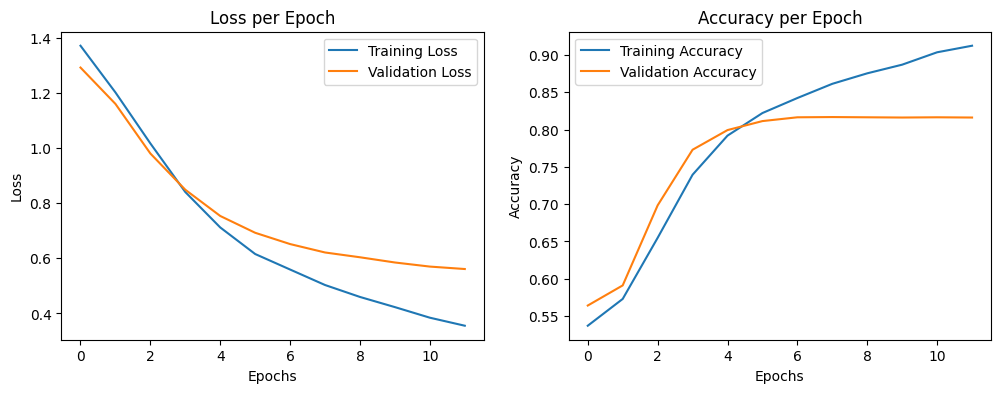

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [34]:
test_loss, test_acc = model.evaluate(testing_padded, testing_labels_final)
print('Test accuracy:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8166 - loss: 0.5481
Test accuracy: 0.8185279369354248


In [35]:
y_pred_prob = model.predict(testing_padded)  # Probabilitas output
y_pred_classes = np.argmax(y_pred_prob, axis=1)

test_loss, test_acc = model.evaluate(testing_padded, testing_labels_final)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8166 - loss: 0.5481
Test Loss: 0.5503
Test Accuracy: 81.85%


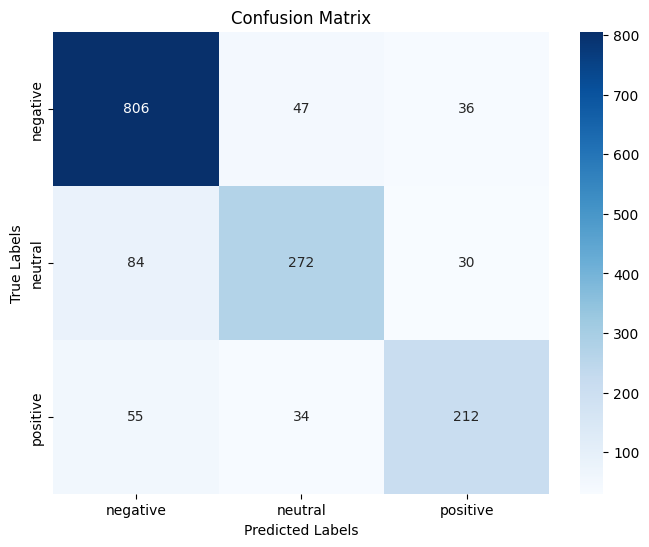

In [36]:
conf_matrix = confusion_matrix(testing_labels_final, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping.keys(), 
            yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
class_report = classification_report(testing_labels_final, y_pred_classes, target_names=label_mapping.keys())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88       889
     neutral       0.77      0.70      0.74       386
    positive       0.76      0.70      0.73       301

    accuracy                           0.82      1576
   macro avg       0.80      0.77      0.78      1576
weighted avg       0.82      0.82      0.82      1576



In [41]:
# Ambil 10 sample acak dari X_test beserta label sentimennya
sample_data = X_test.sample(3, random_state=64).index  
sample_texts = X_test.loc[sample_data].values  
sample_labels = y_test.loc[sample_data].values  

print("\nSample Texts, Actual Labels, and Predicted Sentiments:")
for i, text in enumerate(sample_texts):
   
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length, truncating=trunc_type)
    
    # Prediksi sentiment
    prediction = model.predict(padded_seq)
    sentiment_idx = np.argmax(prediction) 
    predicted_sentiment = list(label_mapping.keys())[sentiment_idx] 
    
    # Ambil label sebenarnya
    actual_sentiment = sample_labels[i] 

    print(f"Text: {text}\nActual Sentiment: {actual_sentiment}\nPredicted Sentiment: {predicted_sentiment}\n")



Sample Texts, Actual Labels, and Predicted Sentiments:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Text:  rekomendasi sih beli iphone baru online kalau toko oren lebih aman dibanding tokopedia gini tokopedia walaupun official store kok gini pelayanannya
Actual Sentiment: positive
Predicted Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Text: beli baru batal system trus da anggap bukan baruapasih mksdnya trus hubungin cs lama nunggu jawab gk nyambung baik layang baru aja kek lgsg trauma lihat tokopedia kek gitu
Actual Sentiment: negative
Predicted Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Text: kalo ngasih rating 10 tak kasih bintang 10 kecewa banget 2x transaksi batal pihak alas batal sistem padahal baru payment mana payment alfa udah ngantri udah bayar admin eh batal pihak udah 2x kalau emang gak langgar sk pas proses payment jangan lolos dong sangatt sangatt kecewaa
Actual Sentiment: negative
Predicted Sentiment: negative



In [42]:
# Contoh teks baru yang ingin Anda prediksi
new_text = ["modus baru penipuan berbelanja barang elektronik di tokopedia Hari pertama. Pesan barang dari Tokopedia, lalu orderan diambil oleh Gojek bernama Hardiansyah, lalu dia membatalkan. Ini oknum yang kami curigai berkomplot dan bersindikat."]

# Ubah teks baru menjadi urutan indeks menggunakan tokenizer yang sudah dilatih
new_sequences = tokenizer.texts_to_sequences(new_text)

# Lakukan padding agar panjangnya sesuai dengan yang digunakan dalam pelatihan
new_padded = pad_sequences(new_sequences, maxlen=max_length, truncating=trunc_type)

# Lakukan prediksi dengan model
prediction = model.predict(new_padded)
sentiment_idx = np.argmax(prediction[0])  # Index dari kelas dengan probabilitas tertinggi
sentiment = list(label_mapping.keys())[sentiment_idx]  # Mapping index ke label sentimen
print(f"Prediksi: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediksi: negative


In [482]:
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [483]:
df['komentar'] = df['komentar'].astype(str).fillna('')

# Now, joining all sentences into a single string
sentences = ' '.join(df['komentar'].tolist())
stopwords_id_en = stopwords.words('indonesian') + ['yg'] + stopwords.words('english')

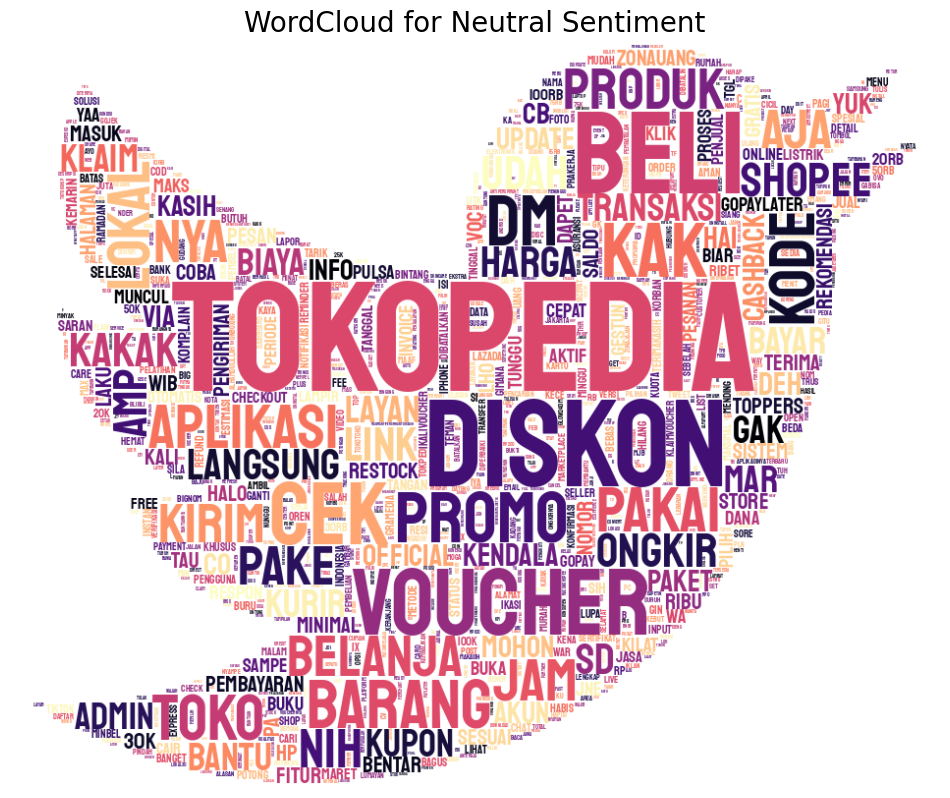

In [484]:
positive_comments = ' '.join(df[df['sentiment'] == 'positive']['komentar'])
neutral_comments = ' '.join(df[df['sentiment'] == 'neutral']['komentar'])
negative_comments = ' '.join(df[df['sentiment'] == 'negative']['komentar'])

# Memuat mask dan font
mask = np.array(Image.open('/Users/alipmaskhuri/skripsi/Dataset/wordcloud/twitter-mask.png'))
font = '/Users/alipmaskhuri/skripsi/Dataset/wordcloud/Staatliches-Regular.ttf'

# Fungsi untuk membuat wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        background_color='white', stopwords=stopwords.words('indonesian') + stopwords.words('english'), 
        mask=mask, font_path=font, 
        random_state=42, max_words=1000,
        width=mask.shape[0], height=mask.shape[1],
        colormap='magma', collocations=False
    ).generate(text)
    
    plt.figure(figsize=(12, 12))
    plt.title(title, fontdict={'size': 20})
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Menampilkan WordCloud untuk sentimen positif, netral, dan negatif
generate_wordcloud(positive_comments, 'WordCloud for Positive Sentiment')
generate_wordcloud(neutral_comments, 'WordCloud for Neutral Sentiment')
generate_wordcloud(negative_comments, 'WordCloud for Negative Sentiment')

In [485]:
model.save('modelfix.keras') 